# *** ONLINE RETAIL ***

## IMPORT AND LOAD DATA

In [40]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from matplotlib import pyplot as plt

df_real = pd.read_excel('C:\\OnlineRetail.xlsx',encoding = 'ISO-8859-1')

In [41]:
df_real.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## CLEANING AND FORMATTING DATA

In [42]:
#Re-ordering the coloumns and creating new dataframe as df

df = df_real[['StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country','InvoiceNo']]

In [43]:
df.head()

,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNo
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,536365
1,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,536365
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,536365
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,536365
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,536365


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   StockCode    541909 non-null  object        
 1   Description  540455 non-null  object        
 2   Quantity     541909 non-null  int64         
 3   InvoiceDate  541909 non-null  datetime64[ns]
 4   UnitPrice    541909 non-null  float64       
 5   CustomerID   406829 non-null  float64       
 6   Country      541909 non-null  object        
 7   InvoiceNo    541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [45]:
# check missing values for each column 

df.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
dtype: int64

In [46]:
# finding empty values in rows(axis defines row)

df[df.isnull().any(axis=1)].head()

# here we drop null values from df

df = df.dropna()

In [47]:
# customer id has floating values; convert them to string

df['CustomerID'] = df['CustomerID'].astype('int64')
df = df[df.Quantity > 0]

In [48]:
#Removing empty invoice number rows

df['Description'] = df['Description'].str.strip()
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)

#Removing credit transactions(invoice number starts with C)

df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]

In [49]:
# Adding year feature to the dataset 

df['year'] = df['InvoiceDate'].dt.year

#Adding month and its name

df['month'] = df['InvoiceDate'].dt.month
df['day'] = df['InvoiceDate'].dt.day
df['hour'] = df['InvoiceDate'].dt.hour

df.head()


#df['monthname'] = df['InvoiceDate'].dt.month_name()
#del df['monthname']

,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNo,year,month,day,hour
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,536365,2010,12,1,8
1,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,536365,2010,12,1,8
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,536365,2010,12,1,8
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,536365,2010,12,1,8
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,536365,2010,12,1,8


## Generating a basket of transactions

In [17]:
#Generation of a basket of transactions

basket = (df
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

#can add df[df['Country'] == 'France'] above

## Formatting inputs as per algo requirement( 0's and 1's)

In [18]:
#CONVERTING TO 0's AND 1's

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)


## GENERATION OF FREQUENT ITEMSET


In [19]:
#GENERATION OF FREQUENT ITEMSET

frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets ,metric="lift", min_threshold=1)

## Modifying rules: sup,conf,lift etc.,

In [55]:
#Taking the variable antecedents length

rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))

In [56]:
#APPLYING LIFT TO CHECK STRENGTH OF THE RULE BY SPECIFYING VALUES

rules[(rules['antecedent_len'] >= 2) & (rules['lift'] >= 1) &
      (rules['confidence'] >= .5)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
70,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.024817,0.042242,0.02104,0.847826,20.070631,0.019992,6.293837,2
71,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023522,0.037279,0.02104,0.894495,23.994742,0.020163,9.124923,2
72,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.029186,0.029996,0.02104,0.720887,24.033032,0.020165,3.475313,2


# COUNTRY SPECIFIC ITEMSET GENERATION

## Frequent Itemsets for United Kingdom

In [20]:
#Generation of basket for United Kingdom

basket_UK = (df[df['Country'] == 'United Kingdom']
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

#can add df[df['Country'] == 'France'] above

In [23]:
#CONVERTING TO 0's AND 1's for United Kingdom

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets_UK = basket_UK.applymap(encode_units)
basket_sets_UK.drop('POSTAGE', inplace=True, axis=1)

#### GENERATION OF FREQUENT ITEMSET


In [24]:
#GENERATION OF FREQUENT ITEMSET FOR United Kingdom

frequent_itemsets_UK = apriori(basket_sets_UK, min_support=0.025, use_colnames=True)
rules_UK = association_rules(frequent_itemsets_UK ,metric="lift", min_threshold=1)

## Frequent Itemsets for Netherland

In [25]:
#Generation of basket for Netherlands

basket_Neth = (df[df['Country'] == 'Netherlands']
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

#can add df[df['Country'] == 'France'] above

In [26]:
#CONVERTING TO 0's AND 1's for Netherlands

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_Neth = basket_Neth.applymap(encode_units)
basket_Neth.drop('POSTAGE', inplace=True, axis=1)

#### GENERATION OF FREQUENT ITEMSET


In [27]:
#GENERATION OF FREQUENT ITEMSET FOR Netherlands

frequent_itemsets_Neth = apriori(basket_Neth, min_support=0.15, use_colnames=True)
rules_Neth = association_rules(frequent_itemsets_Neth ,metric="lift", min_threshold=1)

## Frequent Itemsets for EIRE


In [28]:
#Generation of basket for Ireland

basket_Ireland = (df[df['Country'] == 'EIRE']
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

#can add df[df['Country'] == 'France'] above

In [29]:
#CONVERTING TO 0's AND 1's for Ireland

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_Ireland = basket_Ireland.applymap(encode_units)
#basket_Ireland.drop('POSTAGE', inplace=True, axis=1)

#### GENERATION OF FREQUENT ITEMSET

In [30]:
#GENERATION OF FREQUENT ITEMSET FOR Ireland

frequent_itemsets_Ireland = apriori(basket_Ireland, min_support=0.1, use_colnames=True)
rules_Ireland = association_rules(frequent_itemsets_Ireland ,metric="lift", min_threshold=1)


## Frequent Itemsets for Germany

In [31]:
#Generation of basket for Germany

basket_Germany = (df[df['Country'] == 'Germany']
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

#can add df[df['Country'] == 'France'] above

In [32]:
#CONVERTING TO 0's AND 1's for Germany

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_Germany = basket_Germany.applymap(encode_units)
basket_Germany.drop('POSTAGE', inplace=True, axis=1)

#### GENERATION OF FREQUENT ITEMSET

In [33]:
#GENERATION OF FREQUENT ITEMSET FOR Germany

frequent_itemsets_Germany = apriori(basket_Germany, min_support=0.05, use_colnames=True)
rules_Germany = association_rules(frequent_itemsets_Germany ,metric="lift", min_threshold=1)

## Frequent Itemsets for France


In [34]:
#Generation of basket for France

basket_France = (df[df['Country'] == 'France']
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [35]:
#CONVERTING TO 0's AND 1's for France

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets_France = basket_France.applymap(encode_units)
basket_sets_France.drop('POSTAGE', inplace=True, axis=1)

#### GENERATION OF FREQUENT ITEMSET

In [36]:
#GENERATION OF FREQUENT ITEMSET FOR France

frequent_itemsets_France = apriori(basket_sets_France, min_support=0.1, use_colnames=True)
rules_France = association_rules(frequent_itemsets_France ,metric="lift", min_threshold=1)

# DATA ANALYSIS

In [55]:
#Adding a Column name with total to calculate prices.

Total = df['Quantity'] * df['UnitPrice']
df.insert(loc=7,column='Total',value=Total)

df = df[['CustomerID','Quantity','Description','UnitPrice','Total','InvoiceDate','Country','InvoiceNo','StockCode','month','year','day','hour']]

In [56]:
df.head()

,CustomerID,Quantity,Description,UnitPrice,Total,InvoiceDate,Country,InvoiceNo,StockCode,month,year,day,hour
0,17850,6,WHITE HANGING HEART T-LIGHT HOLDER,2.55,15.30,2010-12-01 08:26:00,United Kingdom,536365,85123A,12,2010,1,8
1,17850,6,WHITE METAL LANTERN,3.39,20.34,2010-12-01 08:26:00,United Kingdom,536365,71053,12,2010,1,8
2,17850,8,CREAM CUPID HEARTS COAT HANGER,2.75,22.00,2010-12-01 08:26:00,United Kingdom,536365,84406B,12,2010,1,8
3,17850,6,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,20.34,2010-12-01 08:26:00,United Kingdom,536365,84029G,12,2010,1,8
4,17850,6,RED WOOLLY HOTTIE WHITE HEART.,3.39,20.34,2010-12-01 08:26:00,United Kingdom,536365,84029E,12,2010,1,8


### Countries sorted by quantities

In [57]:
#Countries sorted by quantities

salesort = df.groupby(['Country'])['Quantity'].sum().sort_values(ascending = False)
salesort

Country
United Kingdom          4269472
Netherlands              200937
EIRE                     140525
Germany                  119263
France                   111472
Australia                 84209
Sweden                    36083
Switzerland               30083
Spain                     27951
Japan                     26016
Belgium                   23237
Norway                    19338
Portugal                  16122
Finland                   10704
Channel Islands            9491
Denmark                    8235
Italy                      8112
Cyprus                     6361
Singapore                  5241
Austria                    4881
Israel                     4046
Poland                     3684
Canada                     2763
Iceland                    2458
USA                        2458
Unspecified                1789
Greece                     1557
United Arab Emirates        982
Malta                       970
Czech Republic              671
Lithuania                   652


In [58]:
#salesort.plot(kind = 'bar', title = 'Quantities of countries')

### Top 5 countries

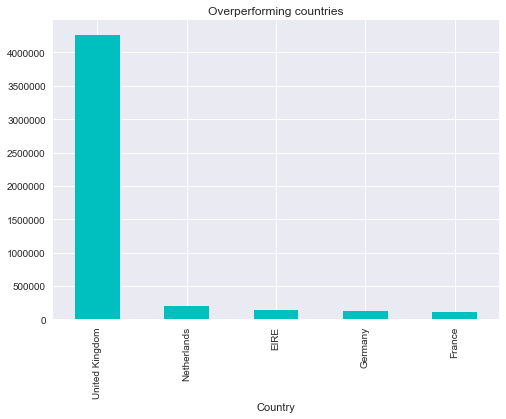

In [59]:
salesort[:5].plot(kind = 'bar', title = 'Overperforming countries', color='c')

### Bottom 5 countries

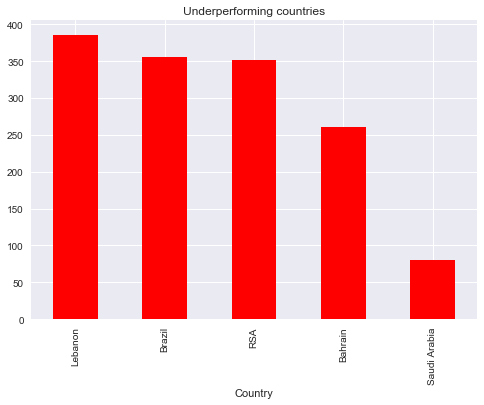

In [60]:
salesort[32:].plot(kind = 'bar', title = 'Underperforming countries', color='red')


### Analysis on number of orders

###### Number of orders by each customer (used customer id and invoice number)

In [61]:
df.groupby(['CustomerID','Country'], as_index=True)['InvoiceNo'].count().head()

CustomerID  Country       
12346       United Kingdom      1
12347       Iceland           182
12348       Finland            31
12349       Italy              73
12350       Norway             17
Name: InvoiceNo, dtype: int64

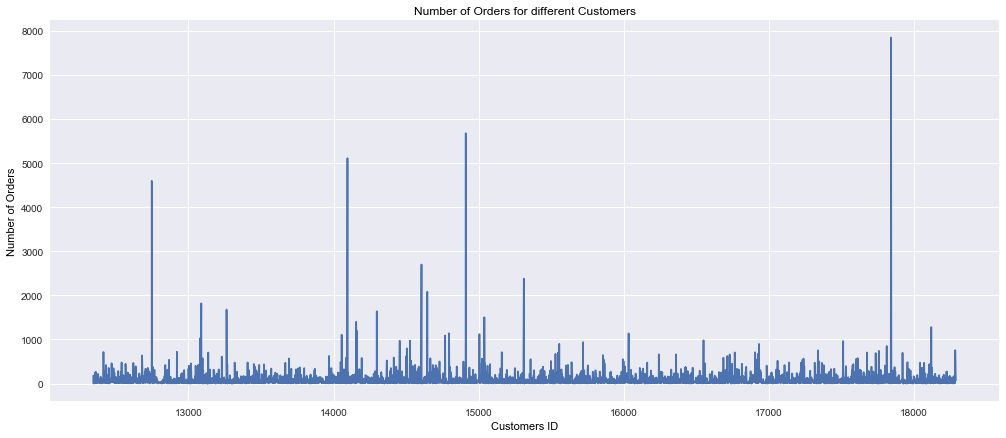

In [62]:
orders = df.groupby(['CustomerID','Country'], as_index=False)['InvoiceNo'].count()
plt.subplots(figsize=(17,7))
plt.style.use('seaborn')
plt.plot(orders.CustomerID, orders.InvoiceNo)
plt.xlabel('Customers ID',color='black')
plt.ylabel('Number of Orders', color='black')
plt.title('Number of Orders for different Customers',color='black')
plt.show()

In [63]:
orders.sort_values(by='InvoiceNo', ascending=False).head()

,CustomerID,Country,InvoiceNo
4019,17841,United Kingdom,7847
1888,14911,EIRE,5677
1298,14096,United Kingdom,5111
334,12748,United Kingdom,4596
1670,14606,United Kingdom,2700


### Top 5 customers with highest orders

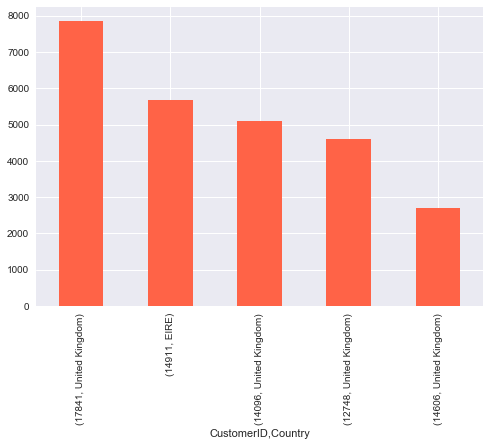

In [64]:
df.groupby(['CustomerID','Country'])['InvoiceNo'].count().sort_values(ascending = False).head().plot(kind = 'bar', color='tomato')

### Money spent by various customers

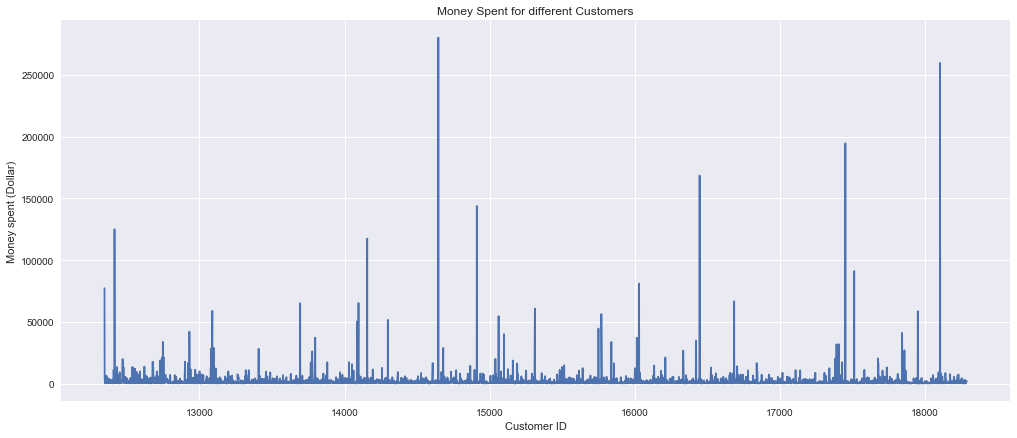

In [65]:
Amount = df.groupby(['CustomerID','Country'], as_index=False)['Total'].sum()

plt.subplots(figsize=(17,7))
plt.plot(Amount.CustomerID, Amount.Total)
plt.xlabel('Customer ID')
plt.ylabel('Money spent (Dollar)')
plt.title('Money Spent for different Customers')
plt.show()

### Top 5 customers who spent the most

In [66]:
Amount.sort_values('Total', ascending=False).head()

,CustomerID,Country,Total
1698,14646,Netherlands,280206.02
4210,18102,United Kingdom,259657.30
3737,17450,United Kingdom,194550.79
3017,16446,United Kingdom,168472.50
1888,14911,EIRE,143825.06


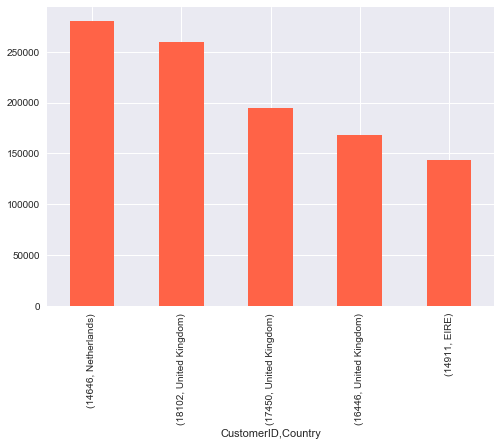

In [36]:
df.groupby(['CustomerID','Country'])['Total'].sum().sort_values(ascending = False).head().plot(kind = 'bar', color='tomato')

### Top 25 Most sold products by Quantity

Text(0, 0.5, 'Quantity')

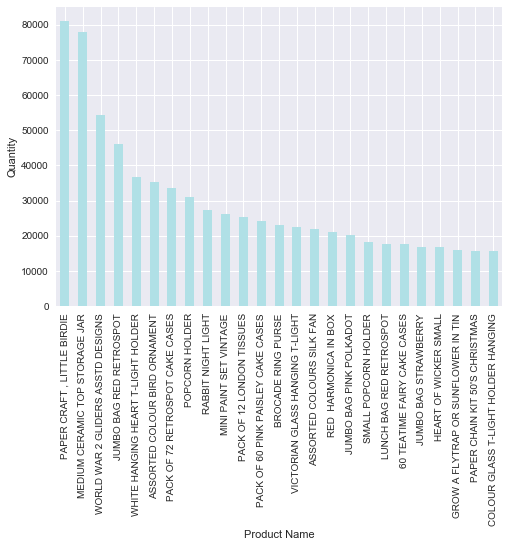

In [37]:
most_sold = df.groupby(['Description'])['Quantity'].sum().sort_values(ascending = False)
top25 = most_sold[0:25].plot(kind = 'bar', color='powderblue')
top25.set_xlabel("Product Name")
top25.set_ylabel("Quantity")

## DIVE DEEPER

### Monthly sales Analysis

Text(0.5, 1.0, 'Monthly Sales')

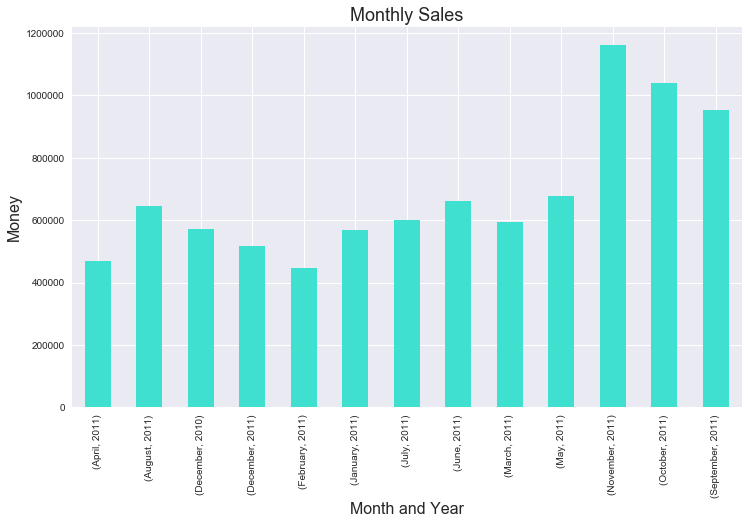

In [38]:
df['monthname'] = df['InvoiceDate'].dt.month_name()

monthly = df.groupby(['monthname','year'])['Total'].sum().plot(kind = 'bar', color = 'turquoise', figsize=(12,7))
monthly.set_xlabel("Month and Year",size=16)
monthly.set_ylabel("Money",size=16)
monthly.set_title("Monthly Sales",size=18)

### Sales for Each day

Text(0.5, 1.0, 'Daily Sales')

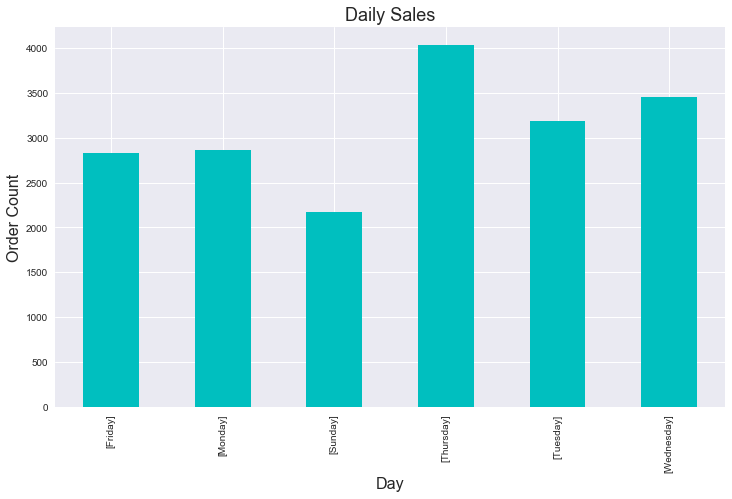

In [39]:
#Added day name attribute to dataframe

df['dayname'] = df['InvoiceDate'].dt.day_name()

daily = df.groupby('InvoiceNo')['dayname'].unique().value_counts().sort_index().plot(kind = 'bar',color = 'c', figsize=(12,7))
daily.set_xlabel("Day",size=16)
daily.set_ylabel("Order Count",size=16)
daily.set_title("Daily Sales",size=18)

### Orders Each Hour

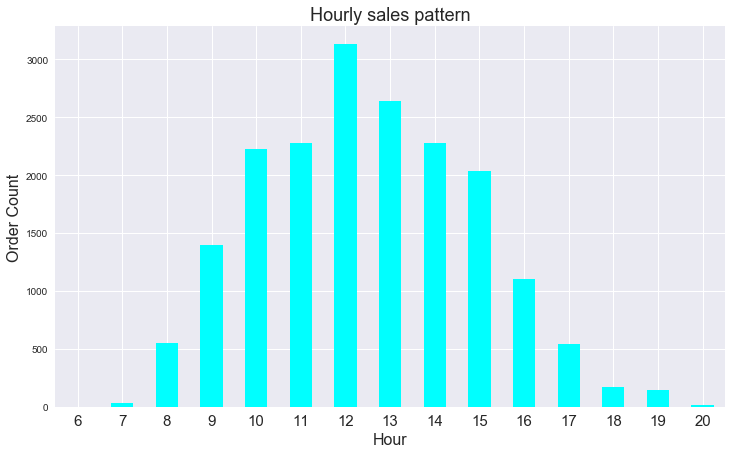

In [40]:
hourly = df.groupby('InvoiceNo')['hour'].unique().value_counts().iloc[:-1].sort_index().plot(kind = 'bar',color = 'aqua', figsize=(12,7))
hourly.set_xlabel("Hour",size=16)
hourly.set_ylabel("Order Count",size=16)
hourly.set_title("Hourly sales pattern",size=18)
hourly.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()



### Checking sales of a specific product over the year

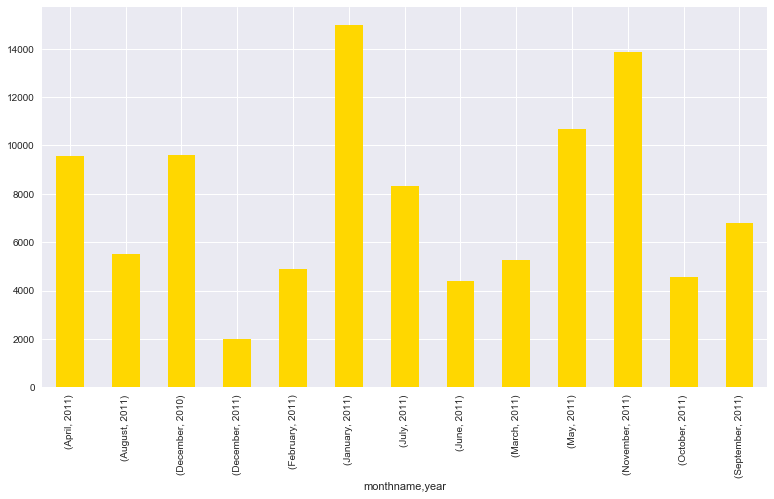

In [41]:
df[df['Description'] == "WHITE HANGING HEART T-LIGHT HOLDER"].groupby(['monthname','year'])['Total'].sum().plot(kind = 'bar',color = 'gold', figsize=(13,7))

In [55]:
r = df[df['Description'] == "RABBIT NIGHT LIGHT"].groupby(['monthname'])['UnitPrice'].unique()
r

monthname
August                   [2.08, 1.79]
December           [1.79, 2.08, 4.13]
July                     [2.08, 1.79]
June                     [1.79, 2.08]
May                      [2.08, 1.79]
November           [2.08, 1.79, 4.13]
October      [4.13, 1.79, 2.08, 1.67]
September          [2.08, 1.79, 4.13]
Name: UnitPrice, dtype: object

In [76]:
s = df[df['Description'] == "NAMASTE SWAGAT INCENSE"].groupby(['Country'])['Quantity'].sum().sort_values(ascending = False)
s

Country
United Kingdom    2391
Iceland             36
Name: Quantity, dtype: int64

In [ ]:
df.groupby(['month','year'])['Total'].sum().plot(kind = 'bar', title = 'Sales month wise')

In [ ]:
#df[df['Description'] == "WHITE HANGING HEART T-LIGHT HOLDER"].groupby(['monthname','year'])['Total'].sum().plot(kind = 'bar',color = 'aqua', figsize=(13,7))

In [ ]:
most_sold[:25]

In [ ]:
df[0:25]

In [77]:
#df['UnitPrice'].plot()

In [78]:
#rules_France[:2]

In [79]:
#rules_UK[:2]

In [80]:
#len(df.Description.unique())